# Imports

In [1]:
# Math
import torch
import numpy as np

# Flair Device
import flair
flair.device = torch.device('cpu')

# Analysis
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# Autoencoder and Dataset Preparation
from data.imdb_preparation import IMDB_preparation
from data.ag_news_preparation import AG_NEWS_preparation
from autoencoders.autoencoder import Autoencoder

# Downloading Packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/bodo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bodo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/bodo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bodo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/bodo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Vanilla Autoencoder

## 1.1 Loading Data

In [2]:
ds = IMDB_preparation()

/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/selecting.py:54: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn("Lambda function is not supported for pickle, please use "


Preparing sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:09<00:00, 100.21it/s]


Making sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:14<00:00, 337.52it/s]


Embedding sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:34<00:00, 716.78it/s]


Splitting sentences...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:02<00:00, 9510.33it/s]

Done!


In [3]:
ds_train, ds_valid = torch.utils.data.random_split(ds, [len(ds) - 1000, 1000])

In [4]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, shuffle=True)

## 1.2 Training loop

In [5]:
m = Autoencoder(100,100,100,4,1,variational=False, max_log2len=8)
Ls_train = []
Ls_valid = []
device = 'cuda'
m = m.to(device)

In [6]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [7]:
m = m.train()
EPOCHS = 6
for e in range(EPOCHS):
    print(f"Epoch: {e}")
    m = m.train()
    pbar = tqdm(dl_train)
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx = m(x_in)
        L = (mx - x_out).pow(2).sum((1,2)).mean()
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()}")
        Ls_train.append(L.item())
    
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())
            

Epoch: 0


VL: 200.3910369873047: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 108.06it/s]


Epoch: 1


VL: 186.03125: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 102.98it/s]


Epoch: 2


VL: 168.48544311523438: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 95.23it/s]


Epoch: 3


VL: 155.50927734375: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 79.36it/s]


Epoch: 4


VL: 147.8302001953125: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 85.60it/s]


Epoch: 5


VL: 164.60699462890625: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 97.40it/s]


In [8]:
torch.save(({'train': Ls_train, 'valid':Ls_valid}, m.state_dict()), 'vanilla_small_6_IMDB.pt')

In [9]:
losses, _ = torch.load('vanilla_small_6_IMDB.pt')

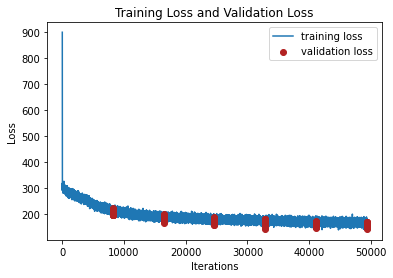

In [10]:
plt.plot(losses['train'], label='training loss')
for i in range(6):
    plt.scatter(
        [(i+1)*263066//32 for _ in range(32)],
        losses['valid'][i*32:(i+1)*32],
        zorder=2,
        c='firebrick',
        label='validation loss' if i == 0 else ''
    )
plt.title('Training Loss and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

The plot above is a comparison of training and validation losses during training. The model has been trained for 6 epochs. After each epoch, a validation loss was calculated (for 32 batches in the validation dataset). The blue line is validation loss per iteration. The red dots are losses for all batches in the validation dataset.

As we can see above, the validation loss closely matches the training loss in terms of mean and deviation. This is expected, as the autoencoder's representation of the sentence is small, the autoencoder itself is small and the dataset is big enough.

The loss does not reduce much during training. Since we do not aim to accuratelly recreate the sentences, but to capture high level features of them, this is expected. The loss keeps decreasing at a very low rate. 

# 2. VAE

## 2.1 Loading Data

In [12]:
ds = IMDB_preparation()

/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/selecting.py:54: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn("Lambda function is not supported for pickle, please use "


Preparing sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:02<00:00, 103.30it/s]


Making sentences...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [29:16<00:00, 14.23it/s]


Embedding sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:43<00:00, 578.33it/s]


Splitting sentences...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:04<00:00, 6181.40it/s]

Done!


In [13]:
ds_train, ds_valid = torch.utils.data.random_split(ds, [len(ds) - 1000, 1000])

In [14]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, shuffle=True)

## 2.2 Training loop

In [11]:
m = Autoencoder(100,100,100,4,1,variational=True,max_log2len=8)
Ls = []
Lsmse = []
Lsvar = []
Ls_train = []
Ls_valid = []
device = 'cuda'
m = m.to(device)

In [12]:
Ls = []
Lsmse = []
Lsvar = []
Ls_train = []
Ls_valid = []

In [13]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [14]:
EPOCHS = 6
beta = 0.1
offset = 5
for e in range(EPOCHS):
    e += offset
    print(f"Epoch: {e}")
    pbar = tqdm(dl_train)
    m = m.train()
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx, (mu, logvar) = m(x_in, return_Z=True)
        Lmse = (mx - x_out).pow(2).sum((1,2)).mean()
        Lvar = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum((1,2)).mean()
        L = Lmse + beta*Lvar
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()} Lmse: {Lmse.item()} Lvar: {Lvar.item()}")
        
        Lsmse.append(Lmse.item())
        Lsvar.append(Lvar.item())
        Ls_train.append(L.item())
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())


Epoch: 5


L: 259.2572937011719 Lmse: 256.5831298828125 Lvar: 26.741491317749023: 100%|████████████████████████████████████████████████████████████| 8221/8221 [04:45<00:00, 28.84it/s]
VL: 290.99517822265625: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 98.04it/s]


Epoch: 6


L: 261.2218933105469 Lmse: 256.3658447265625 Lvar: 48.56063461303711: 100%|█████████████████████████████████████████████████████████████| 8221/8221 [04:42<00:00, 29.07it/s]
VL: 253.50645446777344: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 89.52it/s]


Epoch: 7


L: 218.96182250976562 Lmse: 213.06190490722656 Lvar: 58.999202728271484: 100%|██████████████████████████████████████████████████████████| 8221/8221 [04:56<00:00, 27.69it/s]
VL: 213.58526611328125: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 68.22it/s]


Epoch: 8


L: 217.253173828125 Lmse: 210.64358520507812 Lvar: 66.09590911865234: 100%|█████████████████████████████████████████████████████████████| 8221/8221 [05:04<00:00, 26.99it/s]
VL: 223.31179809570312: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 82.46it/s]


Epoch: 9


L: 215.11268615722656 Lmse: 208.10191345214844 Lvar: 70.10774230957031: 100%|███████████████████████████████████████████████████████████| 8221/8221 [05:08<00:00, 26.61it/s]
VL: 207.70175170898438: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 84.47it/s]


Epoch: 10


L: 200.85028076171875 Lmse: 193.42259216308594 Lvar: 74.27691650390625: 100%|███████████████████████████████████████████████████████████| 8221/8221 [05:07<00:00, 26.75it/s]
VL: 199.0511016845703: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 86.78it/s]


In [15]:
torch.save(({'train': Ls_train, 'valid':Ls_valid, 'mse': Lsmse, 'var': Lsvar}, m.state_dict()), 'vae_small_6_IMDB.pt')

In [16]:
losses, _ = torch.load('vae_small_6_IMDB.pt')

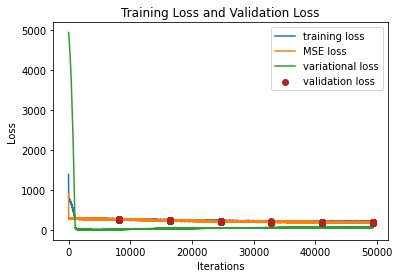

In [17]:
plt.plot(losses['train'], label='training loss')
plt.plot(losses['mse'], label='MSE loss')
plt.plot(losses['var'], label='variational loss')
for i in range(6):
    plt.scatter(
        [(i+1)*263066//32 for _ in range(32)],
        losses['valid'][i*32:(i+1)*32],
        zorder=2,
        c='firebrick',
        label='validation loss' if i == 0 else ''
    )
plt.title('Training Loss and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

The above plot shows the training loss of the variational autoencoder (logarithm). The blue line corresponds to overall loss, the orange one to MSE and the green to variational loss. Overall loss is a sum of the two other losses.

As we can see, the loss is higher than for vanilla autoencoder. The loss falls at a similar rate. Most of the overall loss corresponds to the MSE, as expected. The variational loss quickly falls at the beginning, but rises as the MSE lowers slightly.

The parameters has been tuned in such a way, that the inner representation is regularized enough, for it to be close to the selected distribution for the latent variable. For smaller $\beta$ parameter, the autoencoder would be only something between the true VAE and vanilla autoencoder, while we want to compare results with the variational autoencoder, as it is trained usually. As we will see, this actually does not decrese final performance for few-shot learning.

The validation loss was again close to the training loss.

# 3. Denoising Autoencoder

## 3.1 Loading Data

In [18]:
ds = IMDB_preparation(aug_params={})

Preparing sentences...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:41<00:00, 88.89it/s]


Making sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:45<00:00, 236.41it/s]


Embedding sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:26<00:00, 290.10it/s]


Splitting sentences...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:05<00:00, 4388.46it/s]

Done!


In [19]:
ds_train, ds_valid = torch.utils.data.random_split(ds, [len(ds) - 1000, 1000])

In [20]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True, drop_last=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, shuffle=True, drop_last=True)

## 3.2 Training loop

In [21]:
m = Autoencoder(100,100,100,4,1,variational=False, max_log2len=8)
Ls_train = []
Ls_valid = []
device = 'cuda'
m = m.to(device)

In [22]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [23]:
m = m.train()
EPOCHS = 6
for e in range(EPOCHS):
    print(f"Epoch: {e}")
    m = m.train()
    pbar = tqdm(dl_train)
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx = m(x_in)
        L = (mx - x_out).pow(2).sum((1,2)).mean()
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()}")
        Ls_train.append(L.item())
    
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())

Epoch: 0


VL: 256.44866943359375: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 23.38it/s]


Epoch: 1


VL: 237.07540893554688: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 25.23it/s]


Epoch: 2


VL: 233.5945281982422: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 23.13it/s]


Epoch: 3


VL: 234.210693359375: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 22.60it/s]


Epoch: 4


VL: 212.21546936035156: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 23.66it/s]


Epoch: 5


VL: 229.1317138671875: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 23.22it/s]


In [24]:
torch.save(({'train': Ls_train, 'valid':Ls_valid}, m.state_dict()), 'dae_small_6_IMDB.pt')

In [26]:
losses, _ = torch.load('dae_small_6_IMDB.pt')

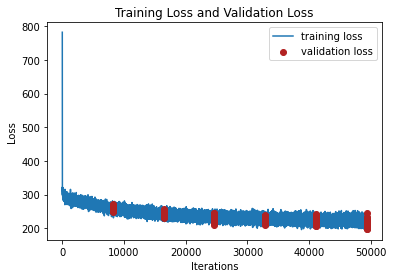

In [27]:
plt.plot(losses['train'], label='training loss')
for i in range(6):
    plt.scatter(
        [(i+1)*263066//32 for _ in range(31)],
        losses['valid'][i*31:(i+1)*31],
        zorder=2,
        c='firebrick',
        label='validation loss' if i == 0 else ''
    )
plt.title('Training Loss and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

As we can see, the training loss and the validation loss look similar to the vanilla autoencoder, however it is higher. This is expected, as the denoising taks makes the prediction much more difficult.